In [4]:
from glob import glob
import os
import sys
sys.path.append(os.pardir)


import cv2
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import rasterio
import rich

from apps.processing_raster import Raster
from apps.raster.color_selecter import ColorMaskHSV
os.chdir('..')

In [51]:
files = glob(os.path.join(os.getcwd(), 'datasets\\images_AOMORI\\*.tiff'))

# True Satellite Imageの処理

In [5]:
color_mask_hsv = ColorMaskHSV()

raster = Raster(files[0])
# 衛星画像の情報を取得
rich.print(raster.infos.summary)

{
    'bands': 3,
    'x_min': 140.672379,
    'x_max': 140.815201,
    'y_min': 40.78925,
    'y_max': 40.877829,
    'raster_rows': 1590,
    'raster_cols': 1303,
    'stats': {
        1: {'min': 0, 'mean': 38.92680316830536, 'q1': 7.0, 'q2': 19.0, 'q3': 67.0, 'max': 255},
        2: {'min': 0, 'mean': 43.61715875797024, 'q1': 15.0, 'q2': 37.0, 'q3': 63.0, 'max': 255},
        3: {'min': 0, 'mean': 38.628429796743845, 'q1': 18.0, 'q2': 21.0, 'q3': 55.0, 'max': 255}
    },
    'epsg': 4326,
    'boundary_poly': <POLYGON ((140.672 40.878, 140.815 40.878, 140.815 40.789, 140.672 40.789, 1...>,
    'boundary_coords': [
        (140.672379, 40.877829),
        (140.815201, 40.877829),
        (140.815201, 40.78925),
        (140.672379, 40.78925),
        (140.672379, 40.877829)
    ],
    'utm_epsg': 6691,
    'raster_width_m': 12033.71846739127,
    'raster_height_m': 9832.832044085488,
    'px_width_m': 6.184171096909112,
    'px_height_m': 9.23539406553436
}

## True Image と HSV ImageのPlot

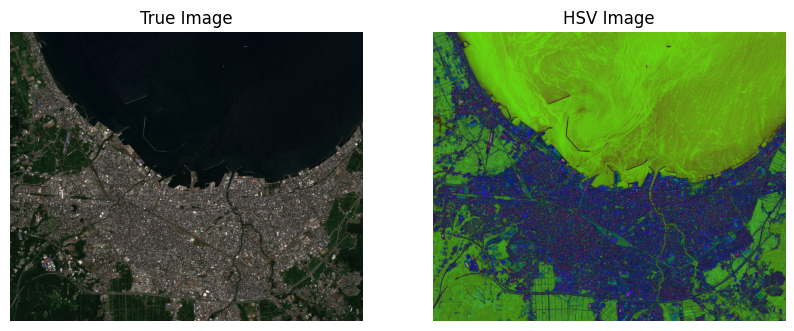

In [10]:
rgb_img = raster.img_ary()
hsv_img = raster.color_converter_use_cv2(rgb_img, cv2.COLOR_RGB2HSV)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
imgs = [rgb_img, hsv_img]
titles = ['True Image', 'HSV Image']
for _ax, title, img in zip(ax, titles, imgs):
    _ax.set_title(title)
    _ax.imshow(img)
    _ax.set_axis_off()
plt.show()

## HSV色空間を使用して画像から特徴を取り出す。

In [13]:
light_green_ranges = color_mask_hsv.light_green_range
masked_light_green_img = raster.masking_rgb_with_hsv(
    rgb_img, 
    hsv_img, 
    light_green_ranges.lower_thres, 
    light_green_ranges.upper_thres,
    response_mask=True
)

dark_green_ranges = color_mask_hsv.dark_green_range
masked_dark_green_img = raster.masking_rgb_with_hsv(
    rgb_img, 
    hsv_img, 
    dark_green_ranges.lower_thres, 
    dark_green_ranges.upper_thres,
    response_mask=True
)

red_ranges = color_mask_hsv.red_range
masked_red_img = raster.masking_rgb_with_hsv(
    rgb_img, 
    hsv_img, 
    red_ranges.lower_thres, 
    red_ranges.upper_thres,
    response_mask=True
)

orange_ranges = color_mask_hsv.orange_range
masked_orange_img = raster.masking_rgb_with_hsv(
    rgb_img, 
    hsv_img, 
    orange_ranges.lower_thres, 
    orange_ranges.upper_thres,
    response_mask=True
)

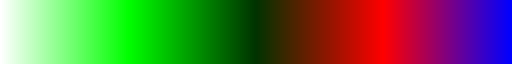

In [47]:
# それぞれの色のマスクにカテゴリーを割り当てる
merged_img = \
    np.where(masked_light_green_img != 0, 60, 0) \
    + np.where(masked_dark_green_img != 0, 120, 0) \
    + np.where(masked_red_img != 0, 180, 0) \
    + np.where(masked_orange_img != 0, 255, 0)


# colormapの作成
items = {
    0: 'white',
    0.25: '#00ff00',
    0.5: '#003300',
    0.75: 'red',
    1.0: 'blue' # orange と red の違いが分かりずらいので
}
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('custom_colormap', list(items.items()))
cmap

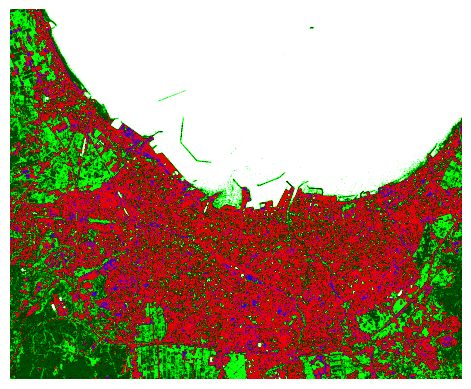

In [50]:
fig, ax = plt.subplots()
ax.imshow(merged_img, cmap=cmap)
ax.set_axis_off();